# CNN - Experiment Template

This notebook serves as the basic template allowing a user to define the dataset and network parameters required for creation of a Convolutional Neural Network. During the evaluation the a variety of different visualisations have been created to allow a user to validate the training and testing of the model.

In [85]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

%matplotlib inline

# Data Reading

In [86]:
# Define the data dimensions
input_dim_model = (3, 50, 50)    # images are 50 x 50 with 3 channels of color (rgb)
input_dim = 50*50*3                # used by readers to treat input data as a vector
num_output_classes = 2

In [87]:
# model dimensions
image_height = 50
image_width  = 50
num_channels = 3
num_classes  = 2

import cntk.io.transforms as xforms 
#
# Define the reader for both training and evaluation action.
#
def create_reader(map_file, train):
    print("Reading map file:", map_file)

    # transformation pipeline for the features when training
    transforms = []

    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels)

    ]
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

The code below ensures that the datasets are available in the specified directories returning an error if the files are not found.

In [88]:
# Ensure the training and test data is available.


data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Tutorials", "data")]:
    
    train_file=os.path.join(data_dir, "train_mapv3.txt")
    test_file=os.path.join(data_dir, "test_mapv3.txt")
    eval_file=os.path.join(data_dir, "eval_test_mapv3.txt")

    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data")
    
print("Data directory is {0}".format(data_dir))

Data directory is ..\Tutorials\data


In [89]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

# Designing the Neural Network model

In [90]:
def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=12, 
                                       strides=(1,1), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(2,2), 
                                    strides=(1,1), name="first_max")(h)
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=24, 
                                       strides=(1,1), 
                                       pad=True, name='second_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(2,2), 
                                    strides=(1,1), name="second_max")(h)
            r = C.layers.Dense(num_output_classes, activation = None, name="classify")(h)
            return r

In [91]:
# Create the model
z = create_model(x)

# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

Output Shape of the first convolution layer: (12, 50, 50)
Bias value of the last dense layer: [0. 0.]


In [92]:
# Number of parameters in the network
C.logging.log_number_of_parameters(z)

Training 113546 parameters in 6 parameter tensors.


The following code contains helper functions such as defining the loss and error calculations for the network, a moving average function, and displaying feedback on training progress.

In [93]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

In [94]:
# Define a utility function to compute the moving average sum.
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error



# Defining the Training and Testing functionality

In [95]:
def plot_progress(minib, evalerr, movingAv, num_minibatches, title):  
    plt.plot(minib, evalerr, color='orange', label='Progress')
    plt.plot(minib, movingAv, markevery=3, color='blue', label='Moving Average')
    plt.plot([0, num_minibatches], [0.5, 0.5], color='darkred', linestyle='--', label='Random Choice')
    plt.xlabel('Minibatch')
    plt.ylabel('Evaluation Error')
    plt.title(title)
    plt.legend()
    plt.show()
    plt.pause(0.5)


def train_test(train_reader, test_reader, model_func, lr , sz, num_sweeps_to_train_with=1):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate = lr
    lr_schedule = C.learning_parameter_schedule(learning_rate)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = 50 #50 is a good minibatch size
    num_samples_per_sweep = sz 
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 100
     
    # Start a timer
    start = time.time()
    global minib
    minib=[]
    evalerr=[]
    global iter_error_list_train
    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
        minib+=[i]
        evalerr+=[trainer.previous_minibatch_evaluation_average]

    movingAv = moving_average(evalerr, w=5)
    iter_error_list_train += [[movingAv]]   
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size = 50
    num_samples = 25000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0

    global minib2

    evalerr2=[]
    minib2=[]
    for i in range(num_minibatches_to_test):
        minibat=i
        # Load test data in batches specified by test_minibatch_size
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error
        minib2+=[i]
        evalerr2+=[eval_error]
    global iter_error_list
    movingAv2 = moving_average(evalerr2, w=5)
    iter_error_list += [[movingAv2]]

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

    print("----------------------------------------------")
    print("Showing results for learning rate: ", lr, " and sample size", sz)
    plot_progress(minib,evalerr, movingAv, num_minibatches_to_train, 'Prediction Error During Training')
    plot_progress(minib2,evalerr2, movingAv2, num_minibatches_to_test, 'Prediction Error During Testing')

# Evaluating the model and creating performance metrics

In [96]:
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def evaluationBitmapAndConfusion(lr, sz):
    global pred
    global predicted_label_prob
    global gtlabel
    global successes
    global successesCancer
    global successesNormal
    global failures
    global failuresCancer
    global failuresNormal
    global img_data
    
    # Read the data for evaluation
    reader_eval=create_reader(test_file, False)

    eval_minibatch_size = 5000
    eval_input_map = {x:reader_eval.streams.features, y:reader_eval.streams.labels} 

    data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

    img_label = data[y].asarray()
    img_data = data[x].asarray()

    # reshape img_data to: M x 3 x 50 x 50 to be compatible with model
    img_data = np.reshape(img_data, (eval_minibatch_size, 3, 50, 50))

    predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]
    #print(predicted_label_prob)

    # Find the index with the maximum value for both predicted as well as the ground truth
    pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
    gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]
    
    np_pred= np.array(pred)

    np_pred = np_pred.reshape(50,100)

    np_pred = np.multiply(np_pred, 255)
    plt.figure(0)
    plt.title('Predictions as a bitmap showing density of classes')
    plt.axis('off')
    plt.imshow(np_pred, cmap="gray")
    plt.pause(0.5)

    successes=[]
    successesCancer=[]
    successesNormal=[]
    failures=[]
    failuresCancer=[]
    failuresNormal=[]
    overall=[]
    sample=0
    test_result = 0
    for i in range(len(pred)):
        sample=i
        if (gtlabel[i] == pred[i]):
            test_result+=1
            successes+=[sample]
            if(pred[i] == 1):
                successesCancer+=[sample]
                overall+=[255]
            else:
                successesNormal+=[sample]
                overall+=[150]
        else:
            failures+=[sample]

            if(pred[i] == 1):
                failuresNormal+=[sample]
                overall+=[75]
            else:
                failuresCancer+=[sample]
                overall+=[0]

    np_overall= np.array(overall)

    np_overall = np_overall.reshape(50,100)

    #plt.figure(1)
    #plt.title('Predictions as a bitmap of successes and failures')
    #plt.axis('off')
    #plt.imshow(np_overall, cmap="cool")
    #plt.pause(0.5)

    print("Number Of Successful Cancer Diagnoses: ", len(successesCancer))
    print("Number Of Successful Normal Diagnoses: ", len(successesNormal))
    print("Number Of unsuccessful Cancer Diagnoses: ", len(failuresCancer))
    print("Number Of unsuccessful Normal Diagnoses: ", len(failuresNormal))

    print("percentage of correct answers: {0:.2f}%".format(test_result/len(pred)*100))

    cm = confusion_matrix(gtlabel,pred)

    # Calculate chart area size
    leftmargin = 1 # inches
    rightmargin = 1 # inches
    categorysize = 1 # inches
    classNames = ['Normal','Cancer']

    figwidth = leftmargin + rightmargin + (len(classNames) * categorysize)           
    plt.figure(figsize=(figwidth, figwidth))
    plt.imshow(cm, interpolation='nearest', cmap='cool')

    plt.title('Cancer Diagnosis Confusion Matrix - Eval Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),horizontalalignment="center",)
    plt.show()

    #successesCancer#TP
    TP= len(successesCancer)
    #successesNormal#TN
    TN= len(successesNormal)
    
    #failuresCancer#FN
    FN= len(failuresCancer)
   
    #failuresNormal#FP
    FP= len(failuresNormal)
    Recall= 0  
    Precision= 0   
    FScore= 0   
    TPR= 0  
    FPR = 0  
    Spec= 0
    

    if(TP != 0 and FN != 0 and FP !=0 and TN != 0):
        #Recall: Out of all the positive classes, how many instances were identified correctly.
        Recall = TP / (TP + FN)  
        #Precision: Out of all the predicted positive instances, how many were predicted correctly.
        Precision = TP / (TP + FP)  
       
        #F-Score: From Precision and Recall. F-score is the harmonic mean of Precision and Recall.
        FScore = (2 * Recall * Precision) / (Recall + Precision)  

        #True Positive Rate = True Positives / (True Positives + False Negatives)
        #Sensitivity = True Positives / (True Positives + False Negatives)
        TPR = TP/(TP + FN)

        #False Positive Rate = False Positives / (False Positives + True Negatives)
        FPR = FP/(FP + TN)

        #Specificity = True Negatives / (True Negatives + False Positives)
        Spec = TN/(TN + FP)

        FPR2 = 1 - Spec
        
    probs=[]
    for i in range(len(pred)):
        probs+=[predicted_label_prob[i][0][pred[i]]]

    # calculate AUC
    auc = roc_auc_score(gtlabel, np.array(probs).astype('float'))
    print('AUC: %.3f' % auc)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(gtlabel, probs)
    
    global FalsePR
    global TruePR
    global Gthresholds
    
    FalsePR += [[fpr]]
    TruePR += [[tpr]]
    Gthresholds += [[thresholds]]
    
    global eval_table
    global eval_index
    eval_index += [[lr,sz]]
    eval_table += [[len(successesCancer),len(successesNormal),len(failuresCancer),len(failuresNormal),
                    test_result/len(pred)*100, Recall, Precision, FScore, TPR, FPR, Spec, auc]]
    

# Iterative experiment cycles- function definition for Error analysis and ROC curves

----------------------------------------------
-------------Sample Size:  8100 ------------
----------------------------------------------
Reading map file: ..\Tutorials\data\train_mapv3.txt
Reading map file: ..\Tutorials\data\test_mapv3.txt
Minibatch: 0, Loss: 0.7200, Error: 52.00%
Minibatch: 100, Loss: 0.6660, Error: 32.00%
Training took 24.6 sec
Average test error: 32.68%
----------------------------------------------
Showing results for learning rate:  0.0022  and sample size 8100


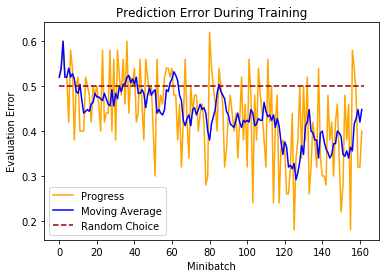

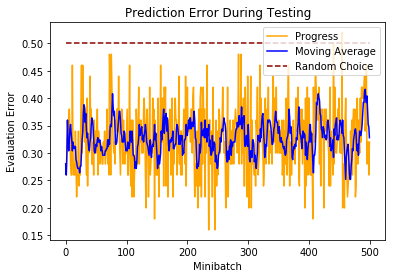

Bias value of the last dense layer: [-0.00664202  0.00664202]
Reading map file: ..\Tutorials\data\test_mapv3.txt


C:\Users\g_osm\Anaconda3\lib\site-packages\cntk\tensor.py:236: UserWarning: converting Value object to CSR format might be slow
  warnings.warn('converting Value object to CSR format might be slow')
C:\Users\g_osm\Anaconda3\lib\site-packages\cntk\tensor.py:244: UserWarning: Cannot convert a sparse NDArrayView or Value object with shape (5000, 1, 2) of rank > 2 to a scipy.csr matrix. Returning dense data.
  ' Returning dense data.' % str(dense_data.shape))


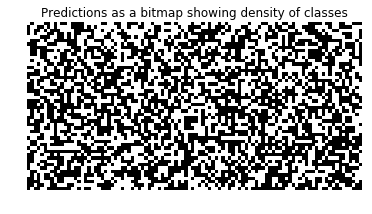

Number Of Successful Cancer Diagnoses:  1757
Number Of Successful Normal Diagnoses:  1863
Number Of unsuccessful Cancer Diagnoses:  777
Number Of unsuccessful Normal Diagnoses:  603
percentage of correct answers: 72.40%


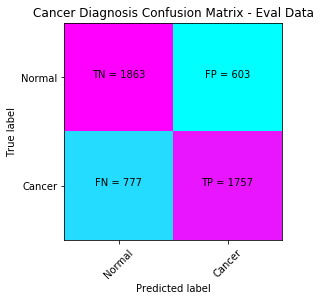

AUC: 0.480


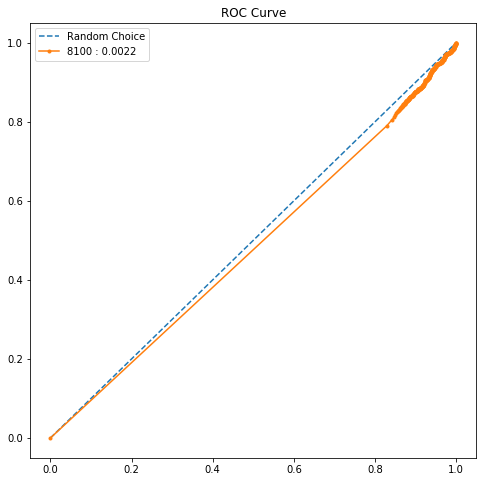

In [97]:
def plot_all_errors(minib, iter_err_list, iter_n, iter_i, title):
    # Calculate chart area size
    leftmargin = 6 # inches
    rightmargin = 6 # inches

    figwidth = leftmargin + rightmargin           
    plt.figure(figsize=(figwidth, figwidth))
    for p in range(len(np.array(iter_err_list))):
        plt.plot(minib, iter_err_list[p][0], markevery=3, label=str(iter_n[p]) + " : " + str(iter_i[p]))
    plt.plot([0, len(minib)], [0.5, 0.5], color='darkred', linestyle='--', label='Random Choice')
    plt.xlabel('Minibatch')
    plt.ylabel('Evaluation Error')
    plt.title(title)
    plt.legend()
    plt.show()
    plt.pause(0.5)

def plot_roc(iter_n, iter_i):
    global FalsePR
    global TruePR
    global Gthresholds
    
    leftmargin = 4 # inches
    rightmargin = 4 # inches

    figwidth = leftmargin + rightmargin           
    plt.figure(figsize=(figwidth, figwidth))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Choice')
    # plot the roc curve for the model
    for i in range(len(FalsePR)):
        plt.plot(FalsePR[i][0], TruePR[i][0], marker='.', label=str(iter_n[i]) + " : " + str(iter_i[i]))
    # show the plot
    plt.legend()
    plt.title("ROC Curve")
    plt.show()

def do_train_test(lr, sz):
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True)
    reader_test = create_reader(test_file, False)
    train_test(reader_train, reader_test, z, lr, sz)

eval_table = []
eval_index = []

for n in range(8100, 8200,200): #Sample size range
    iter_error_list = []
    iter_error_list_train = []
    iter_i = []
    iter_n = []
    minib2 = []
    minib = []
    FalsePR = []
    TruePR=[]
    Gthresholds = []
    successes=[]
    successesCancer=[]
    successesNormal=[]
    failures=[]
    failuresCancer=[]
    failuresNormal=[]
    predicted_label_prob=[]
    gtlabel=[]
    pred=[]
    img_data=[]
    print("----------------------------------------------")
    print("-------------Sample Size: " , n, "------------")
    print("----------------------------------------------")
    for i in range(22, 23, 5): #Learning rate range
        sz = n
        iter_i += [i/10000]
        iter_n += [n]
        
        #Initialise the training and testing
        do_train_test(i/10000, n)
        print("Bias value of the last dense layer:", z.classify.b.value)
        out = C.softmax(z)
        evaluationBitmapAndConfusion(i/10000,n)
        
    #plot_all_errors(minib, iter_error_list_train, iter_n, iter_i, "Training for sample size: " + str(n))
    #plot_all_errors(minib2, iter_error_list, iter_n, iter_i, "Testing for sample size: " + str(n))
    plot_roc(iter_n, iter_i)




# Reviewing the images and prediction outputs

---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing successes for cancer:  0  to  4  with confidence <=  100 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  0


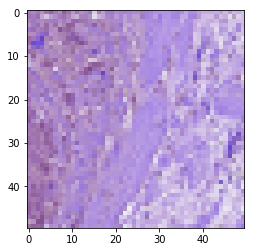

Image Label:  1
Image Prediction:  1
Confidence of Prediction:  99.15 %
Confidence of Alternative:  0.85 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  2


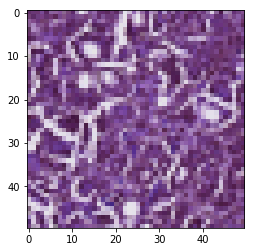

Image Label:  1
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  3


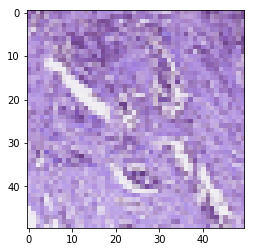

Image Label:  1
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  4


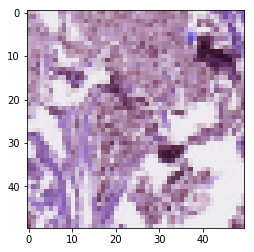

Image Label:  1
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  7


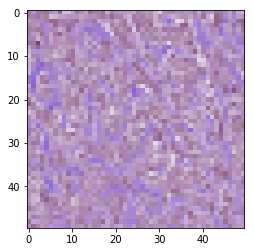

Image Label:  1
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing successes for normal:  0  to  4  with confidence <=  100 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  1


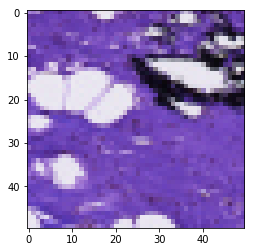

Image Label:  0
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  6


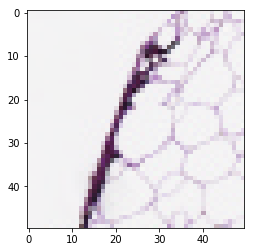

Image Label:  0
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  8


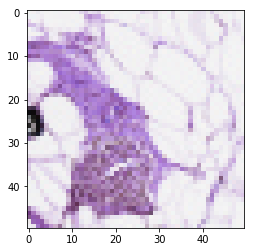

Image Label:  0
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  11


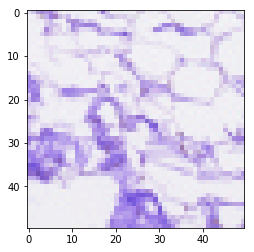

Image Label:  0
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  15


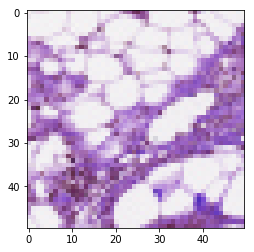

Image Label:  0
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing failures for cancer:  0  to  4  with confidence <=  100 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  5


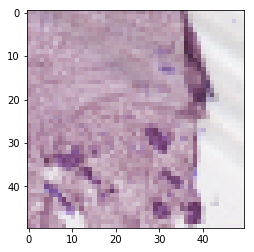

Image Label:  1
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  10


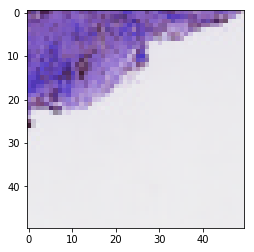

Image Label:  1
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  13


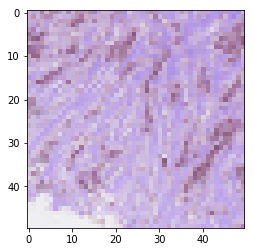

Image Label:  1
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  14


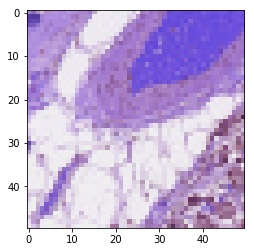

Image Label:  1
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  16


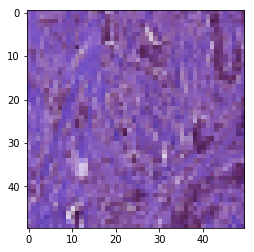

Image Label:  1
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing failures for normal:  0  to  4  with confidence <=  100 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  9


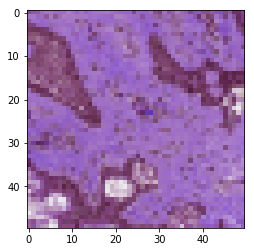

Image Label:  0
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  19


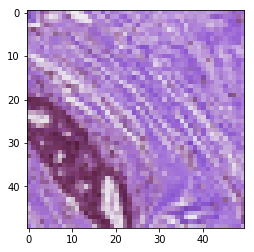

Image Label:  0
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  40


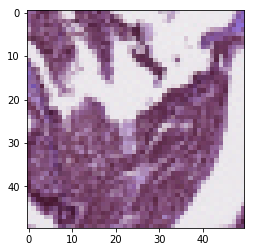

Image Label:  0
Image Prediction:  1
Confidence of Prediction:  99.98 %
Confidence of Alternative:  0.02 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  50


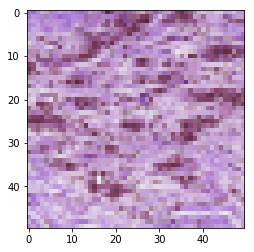

Image Label:  0
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample Number:  65


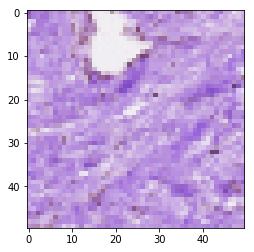

Image Label:  0
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %


<function matplotlib.pyplot.show(*args, **kw)>

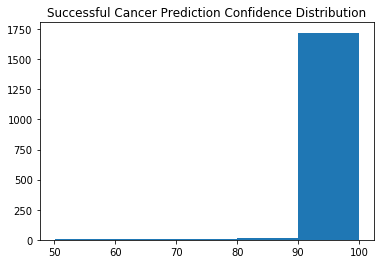

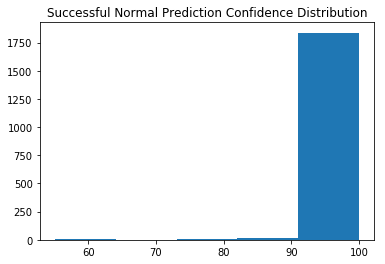

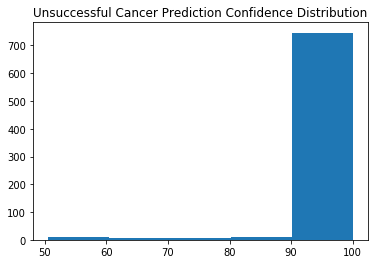

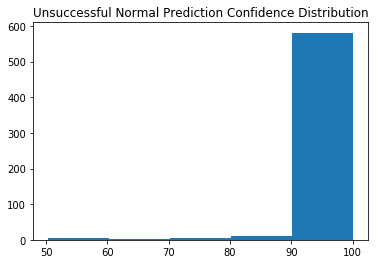

In [98]:
# construct an image
def makeImage(sample_number):
    nparr = np.array(img_data[sample_number])
    nparr3=[]
    nparr4=[]
    nparr5=[]
    for i in range(50):
        nparr4=[]
        for j in range(50):
            nparr4 += [[nparr[0][i][j],nparr[1][i][j],nparr[2][i][j]]]
        nparr3+=[nparr4]
    return nparr3
   
    
def showRange(sample_lb, sample_ub, confidence=100):
    global predicted_label_prob
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")
    print("Showing Samples: ", sample_lb," to ", sample_ub-1, " with confidence <= ", confidence, "%")
    for b in range(sample_lb, sample_ub):
        if(predicted_label_prob[b][0][np.argmax(predicted_label_prob[b])]*100 <= confidence):
            nparrn = np.array(makeImage(b))
            showSlide(nparrn, b)

def showSuccesses(sample_lb, sample_ub, confidence=100):
    global predicted_label_prob
    global successes
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")    
    print("Showing Successes: ", sample_lb," to ", sample_ub-1, " with confidence <= ", confidence, "%")
    for b in successes[sample_lb:sample_ub]:
        if(predicted_label_prob[b][0][np.argmax(predicted_label_prob[b])]*100 <= confidence):
            nparrn = np.array(makeImage(b))
            showSlide(nparrn, b)

def showFailures(sample_lb, sample_ub, confidence=100):
    global predicted_label_prob
    global failures
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")
    print("Showing Failures: ", sample_lb," to ", sample_ub-1, " with confidence <= ", confidence, "%")
    for b in failures[sample_lb:sample_ub]:
        if(predicted_label_prob[b][0][np.argmax(predicted_label_prob[b])]*100 <= confidence):
            nparrn = np.array(makeImage(b))
            showSlide(nparrn, b)
            
            
def showSuccessesCancer(sample_lb, sample_ub, confidence=100):
    global predicted_label_prob
    global successesCancer
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")    
    print("Showing successes for cancer: ", sample_lb," to ", sample_ub-1, " with confidence <= ", confidence, "%")
    for b in successesCancer[sample_lb:sample_ub]:
        if(predicted_label_prob[b][0][np.argmax(predicted_label_prob[b])]*100 <= confidence):
            nparrn = np.array(makeImage(b))
            showSlide(nparrn, b)
            
def showSuccessesNormal(sample_lb, sample_ub, confidence=100):
    global predicted_label_prob
    global successesNormal
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")    
    print("Showing successes for normal: ", sample_lb," to ", sample_ub-1, " with confidence <= ", confidence, "%")
    for b in successesNormal[sample_lb:sample_ub]:
        if(predicted_label_prob[b][0][np.argmax(predicted_label_prob[b])]*100 <= confidence):
            nparrn = np.array(makeImage(b))
            showSlide(nparrn, b)
            
def showFailuresCancer(sample_lb, sample_ub, confidence=100):
    global predicted_label_prob
    global failuresCancer
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")
    print("Showing failures for cancer: ", sample_lb," to ", sample_ub-1, " with confidence <= ", confidence, "%")
    for b in failuresCancer[sample_lb:sample_ub]:
        if(predicted_label_prob[b][0][np.argmax(predicted_label_prob[b])]*100 <= confidence):
            nparrn = np.array(makeImage(b))
            showSlide(nparrn, b)
            
def showFailuresNormal(sample_lb, sample_ub, confidence=100):
    global predicted_label_prob
    global failuresNormal
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")
    print("Showing failures for normal: ", sample_lb," to ", sample_ub-1, " with confidence <= ", confidence, "%")
    for b in failuresNormal[sample_lb:sample_ub]:
        if(predicted_label_prob[b][0][np.argmax(predicted_label_prob[b])]*100 <= confidence):
            nparrn = np.array(makeImage(b))
            showSlide(nparrn, b)
                      

def showSlide(nparrn, b):
    global gtlabel
    global pred
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")
    print("Image Sample Number: ", b)
    plt.figure(b)
    plt.imshow(nparrn.astype(np.uint8))
    plt.show
    plt.pause(0.5)
    img_gt, img_pred = gtlabel[b], pred[b]
    print("Image Label: ", img_gt)
    print("Image Prediction: ", img_pred)
    print("Confidence of Prediction: ", round(predicted_label_prob[b][0][np.argmax(predicted_label_prob[b])]*100,2),"%")
    print("Confidence of Alternative: ", round(predicted_label_prob[b][0][np.argmin(predicted_label_prob[b])]*100, 2),"%")


#user defines sample upper and lower bounds and the maximum confidence of probability to be listed.
sample_lb = 0
sample_ub = 5
confidence = 100 #find less confident values

#The commented functions below are to be used as a switch for users to display different images.

#showSuccesses(sample_lb, sample_ub, confidence)
showSuccessesCancer(sample_lb, sample_ub, confidence)
showSuccessesNormal(sample_lb, sample_ub, confidence)

#showFailures(sample_lb, sample_ub, confidence)
showFailuresCancer(sample_lb, sample_ub, confidence)
showFailuresNormal(sample_lb, sample_ub, confidence)

#showRange(sample_lb, sample_ub, confidence)

histplotSC = []
histplotSN = []
histplotFC = []
histplotFN = []
global predicted_label_prob
for p in successesCancer:
    histplotSC+=[round(predicted_label_prob[p][0][np.argmax(predicted_label_prob[p])]*100,2)]
    
for q in successesNormal:
    histplotSN+=[round(predicted_label_prob[q][0][np.argmax(predicted_label_prob[q])]*100,2)]
    
for r in failuresCancer:
    histplotFC+=[round(predicted_label_prob[r][0][np.argmax(predicted_label_prob[r])]*100,2)]
    
for s in failuresNormal:
    histplotFN+=[round(predicted_label_prob[s][0][np.argmax(predicted_label_prob[s])]*100,2)]
    
np_histplotSC = np.array(histplotSC)
np_histplotSN = np.array(histplotSN)
np_histplotFC = np.array(histplotFC)
np_histplotFN = np.array(histplotFN)

#print(np_histplotSC.shape)
#print(np_histplotSN.shape)
#print(np_histplotFC.shape)
#print(np_histplotFN.shape)

plt.figure(0)
plt.hist(np_histplotSC,bins=5)
plt.title('Successful Cancer Prediction Confidence Distribution')
plt.show
plt.figure(1)
plt.hist(np_histplotSN,bins=5)
plt.title('Successful Normal Prediction Confidence Distribution')
plt.show
plt.figure(2)
plt.hist(np_histplotFC,bins=5)
plt.title('Unsuccessful Cancer Prediction Confidence Distribution')
plt.show
plt.figure(3)
plt.hist(np_histplotFN,bins=5)
plt.title('Unsuccessful Normal Prediction Confidence Distribution')
plt.show


# Outputting performance metrics to a csv file for external analysis

In [99]:
import numpy as np
import pandas as pd
# Creating a 2 dimensional numpy array
data= np.array(eval_table).astype(float)

ind = []

for g in range(len(eval_index)):
    eval_ind = str(eval_index[g][1]) + " - LR = " + str(eval_index[g][0])
    ind += [eval_ind]

#Creating pandas dataframe from numpy array
dataset = pd.DataFrame(data[:,[0,1,2,3,4,5,6,7,8,9,10,11]].astype(float), index = ind[:], columns = ['True Cancer',
                        'True Normal',
                        'False Cancer',
                        'False Normal',
                        'Accuracy',
                        'Recall', 
                        'Precision', 
                        'F-Score', 'TPR/Sensitivity', 'FPR', 'Specificity','AUC'])
print(dataset)

dataset2 = pd.DataFrame(data[:,4],index = ind[:], columns = ['% Correct Answers'])
print(dataset2)

export_csv = dataset.to_csv(r'C:\Users\g_osm\CNTK-Samples-2-6\Tutorials\Eval_Matrix.csv')
export_csv = dataset2.to_csv(r'C:\Users\g_osm\CNTK-Samples-2-6\Tutorials\AccuracyBySampleSizeAndLR.csv')

                    True Cancer  True Normal  False Cancer  False Normal  \
8100 - LR = 0.0022       1757.0       1863.0         777.0         603.0   

                    Accuracy   Recall  Precision   F-Score  TPR/Sensitivity  \
8100 - LR = 0.0022      72.4  0.69337   0.744492  0.718022          0.69337   

                         FPR  Specificity       AUC  
8100 - LR = 0.0022  0.244526     0.755474  0.480209  
                    % Correct Answers
8100 - LR = 0.0022               72.4


## Identifying models with AUC above a defined threshold

In [100]:
filterdf = dataset2[dataset['AUC'] > 0.55]
filterdf2 = dataset[dataset['AUC'] > 0.55]
print(filterdf)
print(filterdf2.loc[: , "AUC"])

Empty DataFrame
Columns: [% Correct Answers]
Index: []
Series([], Name: AUC, dtype: float64)


# Reading hidden layers and producing attention maps for evaluation

Reading map file: ..\Tutorials\data\one_mapv1.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing Samples: ..\Tutorials\data\one_mapv1.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample:  ..\Tutorials\data\one_mapv1.txt


C:\Users\g_osm\Anaconda3\lib\site-packages\cntk\tensor.py:236: UserWarning: converting Value object to CSR format might be slow
  warnings.warn('converting Value object to CSR format might be slow')
C:\Users\g_osm\Anaconda3\lib\site-packages\cntk\tensor.py:244: UserWarning: Cannot convert a sparse NDArrayView or Value object with shape (1, 1, 2) of rank > 2 to a scipy.csr matrix. Returning dense data.
  ' Returning dense data.' % str(dense_data.shape))


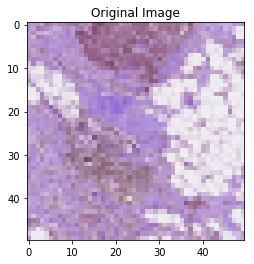

Image Label:  1
Image Prediction:  0
Confidence of Prediction:  99.77 %
Confidence of Alternative:  0.23199552670121193 %
Reading map file: ..\Tutorials\data\one_mapv1.txt
(50, 50)
(1, 12, 50, 50)


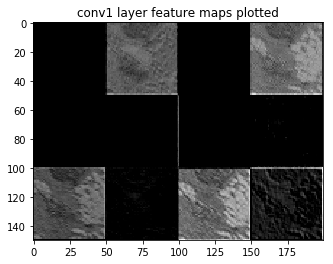

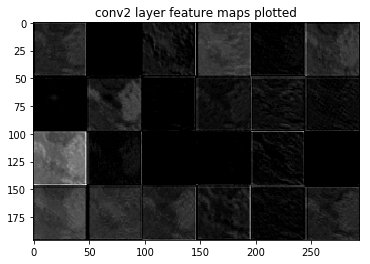

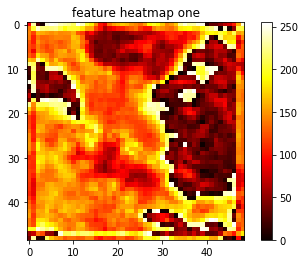

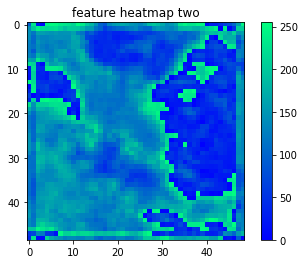

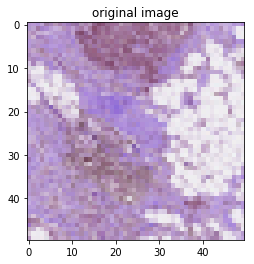

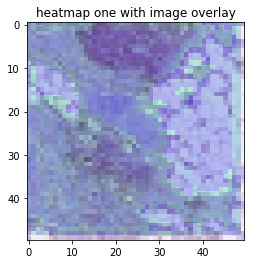

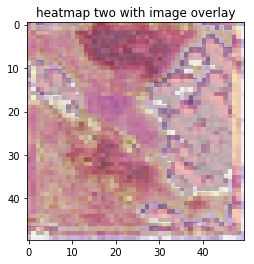

Reading map file: ..\Tutorials\data\one_mapv2.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing Samples: ..\Tutorials\data\one_mapv2.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample:  ..\Tutorials\data\one_mapv2.txt


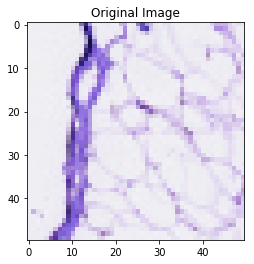

Image Label:  0
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
Reading map file: ..\Tutorials\data\one_mapv2.txt
(50, 50)
(1, 12, 50, 50)


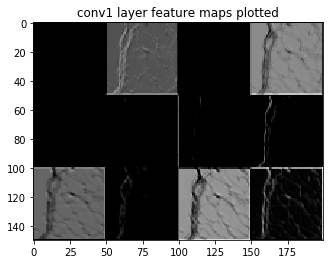

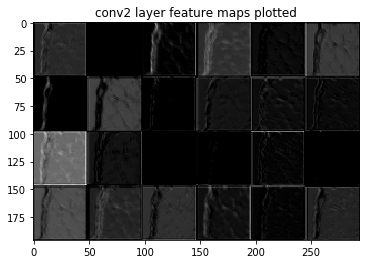

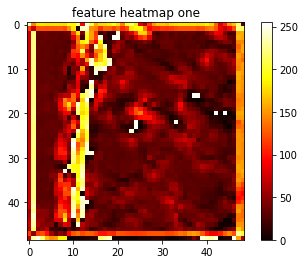

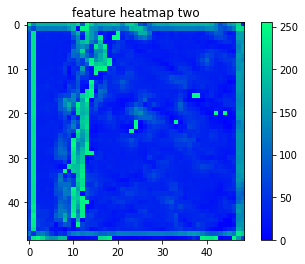

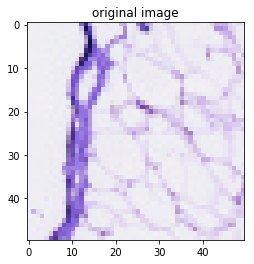

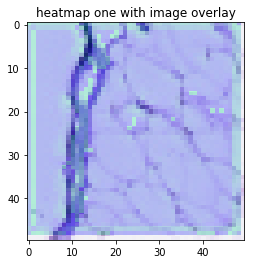

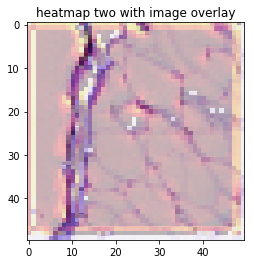

Reading map file: ..\Tutorials\data\one_mapv3.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing Samples: ..\Tutorials\data\one_mapv3.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample:  ..\Tutorials\data\one_mapv3.txt


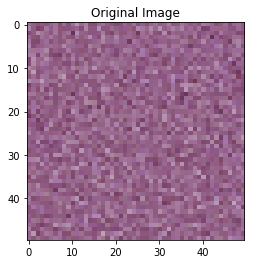

Image Label:  1
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  9.866660101567528e-21 %
Reading map file: ..\Tutorials\data\one_mapv3.txt
(50, 50)
(1, 12, 50, 50)


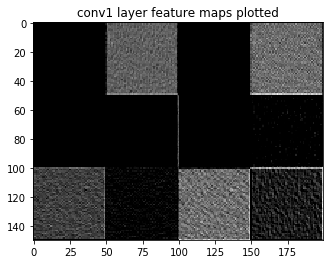

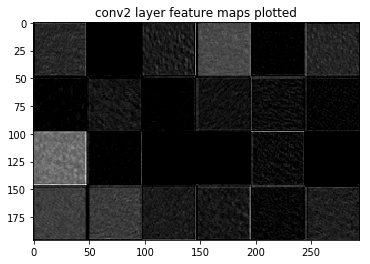

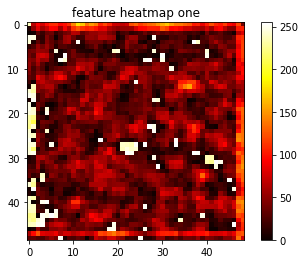

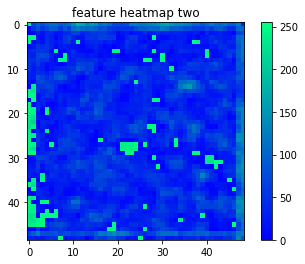

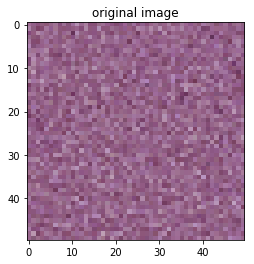

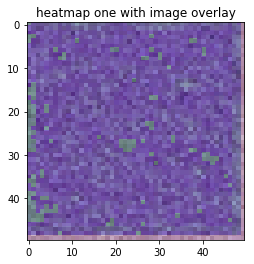

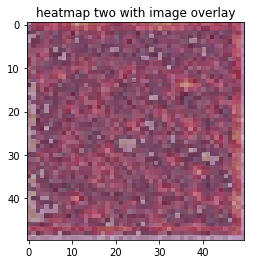

Reading map file: ..\Tutorials\data\one_mapv4.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing Samples: ..\Tutorials\data\one_mapv4.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample:  ..\Tutorials\data\one_mapv4.txt


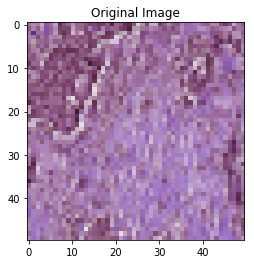

Image Label:  1
Image Prediction:  1
Confidence of Prediction:  100.0 %
Confidence of Alternative:  1.4872506055172242e-31 %
Reading map file: ..\Tutorials\data\one_mapv4.txt
(50, 50)
(1, 12, 50, 50)


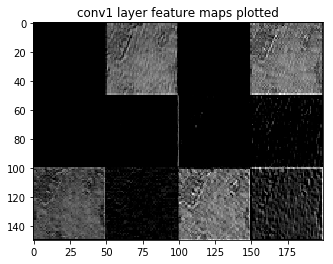

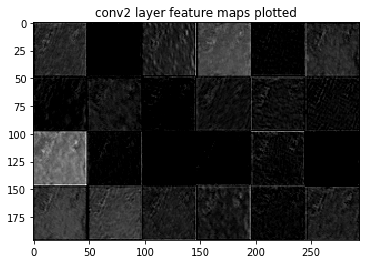

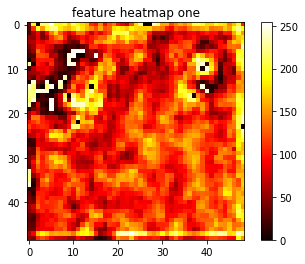

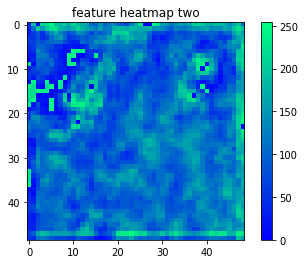

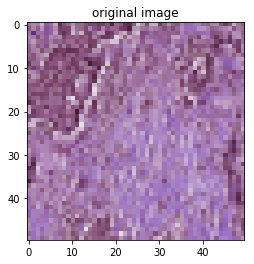

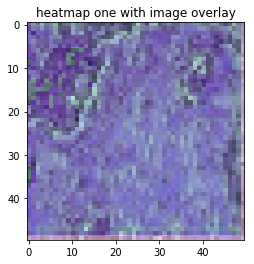

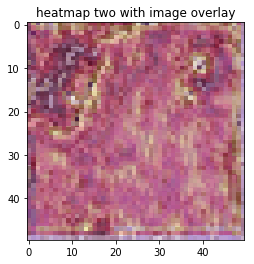

Reading map file: ..\Tutorials\data\one_mapv5.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Showing Samples: ..\Tutorials\data\one_mapv5.txt
---------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------
Image Sample:  ..\Tutorials\data\one_mapv5.txt


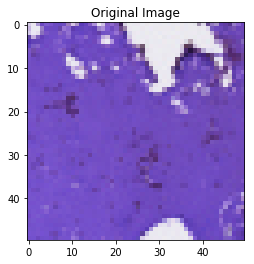

Image Label:  0
Image Prediction:  0
Confidence of Prediction:  100.0 %
Confidence of Alternative:  0.0 %
Reading map file: ..\Tutorials\data\one_mapv5.txt
(50, 50)
(1, 12, 50, 50)


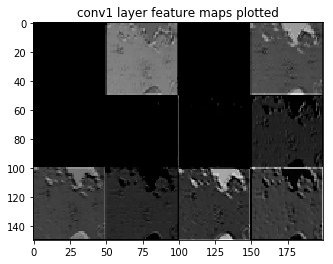

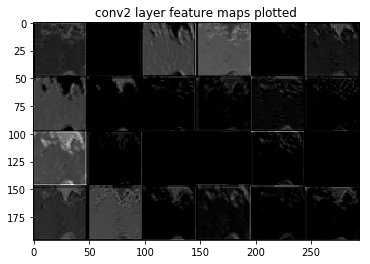

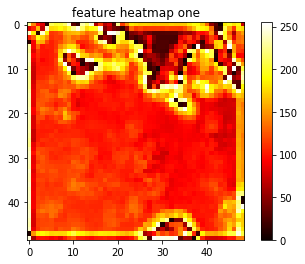

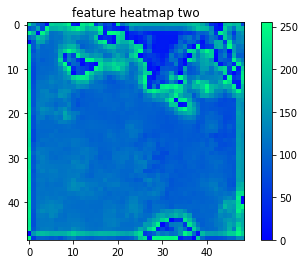

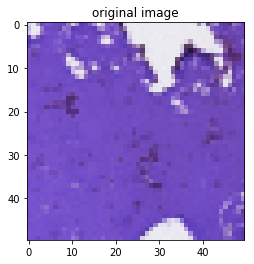

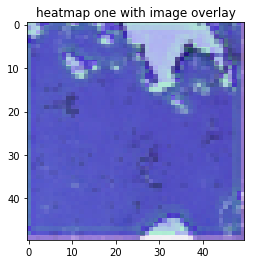

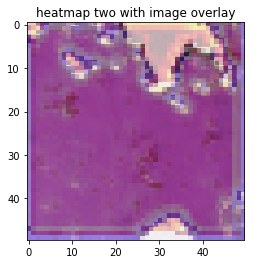

In [101]:
from cntk import load_model, combine
import cntk.io.transforms as xforms
from cntk.logging import graph
from cntk.logging.graph import get_node_outputs

def eval_and_write(node_name, output_file, minibatch_source, num_objects):
    # load model and pick desired node as output

    node_in_graph = z.find_by_name(node_name)
    output_nodes  = combine([node_in_graph.owner])

    # evaluate model and get desired node output
    #print("Evaluating model for output node %s" % node_name)
    features_si = minibatch_source['features']

    for i in range(0, num_objects):
        mb = minibatch_source.next_minibatch(1)
        output = output_nodes.eval(mb[features_si])

    return output

def makeImage2(img_dat,sample_number):
    nparr = np.array(img_dat[sample_number])
    nparr3=[]
    nparr4=[]
    nparr5=[]
    for i in range(50):
        nparr4=[]
        for j in range(50):
            nparr4 += [[nparr[0][i][j],nparr[1][i][j],nparr[2][i][j]]]
        nparr3+=[nparr4]
    return nparr3

def TestIndividualImage(image):
    reader_eval2=create_reader(image, False)

    eval_minibatch_size = 1
    eval_input_map = {x:reader_eval2.streams.features, y:reader_eval2.streams.labels} 

    data = reader_eval2.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

    img_lab = data[y].asarray()
    img_dat = data[x].asarray()

    # reshape img_data to: M x 3 x 50 x 50 to be compatible with model
    img_dat = np.reshape(img_dat, (eval_minibatch_size, 3, 50, 50))

    predicted_lab_prob = [out.eval(img_dat[i]) for i in range(len(img_dat))]
    #print(predicted_label_prob)

    # Find the index with the maximum value for both predicted as well as the ground truth
    predi = [np.argmax(predicted_lab_prob[i]) for i in range(len(predicted_lab_prob))]
    gtlab = [np.argmax(img_lab[i]) for i in range(len(img_lab))]

    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")
    print("Showing Samples:", image)
    nparrn = np.array(makeImage2(img_dat, 0))
    print("---------------------------------------------------------------------------------------------------------------")
    print("---------------------------------------------------------------------------------------------------------------")
    print("Image Sample: ", image)
    plt.figure(0)
    plt.title('Original Image')
    plt.imshow(nparrn.astype(np.uint8))
    plt.show
    plt.pause(0.5)
    img_gt, img_pred = gtlab[0], predi[0]
    print("Image Label: ", img_gt)
    print("Image Prediction: ", img_pred)
    print("Confidence of Prediction: ", round(predicted_lab_prob[0][0][np.argmax(predicted_lab_prob[0])]*100,2),"%")
    print("Confidence of Alternative: ", predicted_lab_prob[0][0][np.argmin(predicted_lab_prob[0])]*100,"%")

    image_height = 50
    image_width  = 50
    num_channels = 3

    # use this to get the features of a layer
    node_name = "second_conv"
    node_name2 = "first_conv"
    output_file = ""#os.path.join(base_folder, "layerOutput.txt")

    # evaluate model and write out the desired layer output
    minibatch_source = create_reader(image, False)
    lfarr = eval_and_write(node_name, output_file, minibatch_source, num_objects=1)
    lfarr2= eval_and_write(node_name2, output_file, minibatch_source, num_objects=1)

    #conv2 layer feature maps
    nplfarr = np.array(lfarr).astype(np.uint8)

    #stitching the feature maps together to form a 4x6 (RowsxCols) set of images
    newlfarr= nplfarr[0][0]
    for i in range(1,6):
        newlfarr= np.concatenate((newlfarr, nplfarr[0][i]),axis=1)
    #print(newlfarr.shape)

    newlfarr2= nplfarr[0][6]
    for i in range(7,12):
        newlfarr2= np.concatenate((newlfarr2, nplfarr[0][i]),axis=1)
    #print(newlfarr2.shape)

    newlfarr3= nplfarr[0][12]
    for i in range(13,18):
        newlfarr3= np.concatenate((newlfarr3, nplfarr[0][i]),axis=1)

    newlfarr4= nplfarr[0][18]
    for i in range(19,24):
        newlfarr4= np.concatenate((newlfarr4, nplfarr[0][i]),axis=1)

    newlfarr5=np.concatenate((newlfarr,newlfarr2,newlfarr3,newlfarr4))

    #conv1 layer feature maps
    nplfarr2 = np.array(lfarr2).astype(np.uint8)
    print(nplfarr2[0][0].shape)
    print(nplfarr2.shape)

    newlfarr6= nplfarr2[0][0]
    for i in range(1,4):
        newlfarr6= np.concatenate((newlfarr6, nplfarr2[0][i]),axis=1)
    #print("here",newlfarr6.shape)

    newlfarr7= nplfarr2[0][4]
    for i in range(5,8):
        newlfarr7= np.concatenate((newlfarr7, nplfarr2[0][i]),axis=1)
    #print(newlfarr7.shape)
    
    newlfarr11 = nplfarr2[0][8]
    for i in range(9,12):
        newlfarr11= np.concatenate((newlfarr11, nplfarr2[0][i]),axis=1)
    #print(newlfarr7.shape)

    #conv1 layer feature maps plotted
    newlfarr8=np.concatenate((newlfarr6,newlfarr7,newlfarr11))
    plt.figure(2)
    plt.title('conv1 layer feature maps plotted')
    plt.imshow(newlfarr8, cmap="gray")
    plt.show
    plt.pause(0.5)
    
    #conv2 layer feature maps plotted
    plt.figure(1)
    plt.title('conv2 layer feature maps plotted')
    plt.imshow(newlfarr5, cmap="gray")
    plt.show
    plt.pause(0.5)
    
    #create heatmap by adding up all feature maps from conv2 layer
    newlfarr9= nplfarr[0][0]
    for i in range(1,24):
            newlfarr9= newlfarr9 + nplfarr[0][i]
            
    
    #feature heatmap one
    plt.figure(3)
    plt.title('feature heatmap one')
    plt.imshow(newlfarr9, cmap="hot")
    plt.colorbar()
    plt.show
    plt.pause(0.5)
    
    #feature heatmap two        
    plt.figure(4)
    plt.title('feature heatmap two')
    plt.imshow(newlfarr9, cmap="winter")
    plt.colorbar()
    plt.show
    plt.pause(0.5)
    
    #original image
    plt.figure(5)
    plt.title('original image')
    plt.imshow(nparrn.astype(np.uint8))
    plt.show
    plt.pause(0.5)
    img_gt, img_pred = gtlab[0], predi[0]
    
    #heatmap with image overlay
    plt.figure(6)
    plt.title('heatmap one with image overlay')
    img3 = plt.imshow(newlfarr9,cmap='winter')
    img2 = plt.imshow(nparrn.astype(np.uint8), alpha=0.75)
    plt.show
    plt.pause(0.5)
    img_gt, img_pred = gtlab[0], predi[0]
    
    #heatmap two with image overlay
    plt.figure(7)
    plt.title('heatmap two with image overlay')
    img3 = plt.imshow(newlfarr9,cmap='hot')
    img2 = plt.imshow(nparrn.astype(np.uint8) ,alpha=0.75)
    plt.show
    plt.pause(0.5)
    img_gt, img_pred = gtlab[0], predi[0]


one_map1=os.path.join(data_dir, "one_mapv1.txt")
one_map2=os.path.join(data_dir, "one_mapv2.txt")
one_map3=os.path.join(data_dir, "one_mapv3.txt")
one_map4=os.path.join(data_dir, "one_mapv4.txt")
one_map5=os.path.join(data_dir, "one_mapv5.txt")
one_map2=os.path.join(data_dir, "one_mapv2.txt")

TestIndividualImage(one_map1)
TestIndividualImage(one_map2)
TestIndividualImage(one_map3)
TestIndividualImage(one_map4)
TestIndividualImage(one_map5)


In [102]:
import pydot_ng

stuff = C.logging.graph.plot(z, 'model.png')

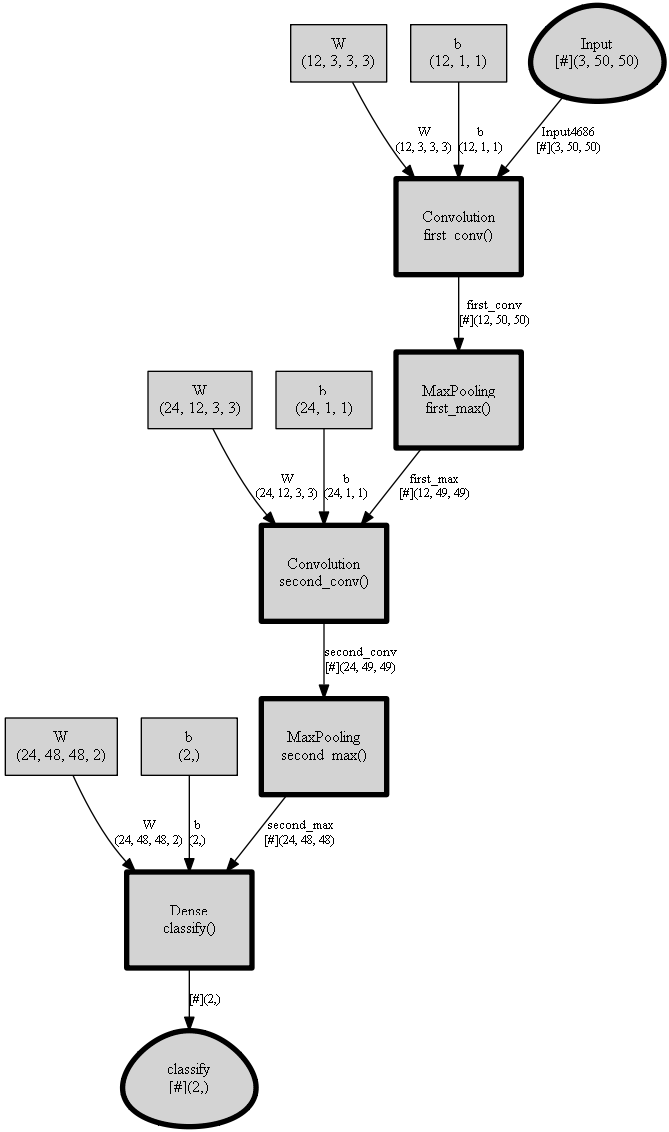

In [103]:
from IPython.display import Image

display(Image(filename="model.png"))